In [1]:

train_data_dir = '/home/vitalii/Desktop/NASA/fire_detection/notebooks/datasets/FireIds'

test_data_dir = '/home/vitalii/Desktop/NASA/fire_detection/notebooks/datasets/Validation'

models_dir = '/home/vitalii/Desktop/NASA/fire_detection/notebooks/models/'

vgg16_name = 'vgg16_weights.h5'

fire_vgg16_name = 'fire_vgg16_weights2.h5'

fire_model = 'fire_detection'

In [2]:
import random
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [3]:
from PIL import Image
print(Image.__file__)

/home/vitalii/Desktop/NASA/fire_detection/venv_2/local/lib/python2.7/site-packages/PIL/Image.pyc


In [4]:
import Image
print(Image.__file__)

/home/vitalii/Desktop/NASA/fire_detection/venv_2/local/lib/python2.7/site-packages/PIL/Image.pyc


In [5]:
train_data_dir

'/home/vitalii/Desktop/NASA/fire_detection/notebooks/datasets/FireIds'

In [6]:
nb_train_samples = 1000

nb_test_samples = 250

In [7]:
import numpy as np
import numpy.random as nr
import os
os.environ['THEANO_FLAGS'] = "device=gpu0,floatX=float32"  

In [8]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.pyplot as plot
from keras import utils
import h5py
import np_utils

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import np_utils

import sys
from my_keras_utilities import TrainingPlotter, load_model_and_history

K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [9]:
def get_tr_vgg_model(weights_path, img_width, img_height):
    
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    print ('Model loaded.')
    
    return model

# Carregando e Normalizando os dados

In [10]:
fire_train_files = os.listdir(train_data_dir+'/fire')
fire_test_files  = os.listdir(test_data_dir +'/fire')

not_fire_train_files = os.listdir(train_data_dir+'/not_fire')
not_fire_test_files  = os.listdir(test_data_dir +'/not_fire')

In [11]:
len(fire_train_files)

5290

In [12]:
len(fire_test_files)

1352

In [13]:
len(not_fire_train_files)

5604

In [14]:
len(not_fire_test_files)

2852

In [15]:
random.shuffle(fire_train_files)
random.shuffle(fire_train_files)
random.shuffle(fire_test_files)
random.shuffle(fire_test_files)
random.shuffle(not_fire_train_files)
random.shuffle(not_fire_train_files)
random.shuffle(not_fire_test_files)
random.shuffle(not_fire_test_files)

In [16]:

image_train_filenames = []
for i in range(0,nb_train_samples):
    fn = '{}/fire/{}'.format(train_data_dir, fire_train_files[i])
    image_train_filenames.append(fn)
    fn = '{}/not_fire/{}'.format(train_data_dir, not_fire_train_files[i])
    image_train_filenames.append(fn)
    
image_test_filenames = []
for i in range(0,nb_test_samples):
    fn = '{}/fire/{}'.format(test_data_dir, fire_test_files[i])
    image_test_filenames.append(fn)
    fn = '{}/not_fire/{}'.format(test_data_dir, not_fire_test_files[i])
    image_test_filenames.append(fn)
    
img_width, img_height = 150, 200 #85, 128 #340, 512

X_train = np.empty((2*nb_train_samples, 3, img_width, img_height), np.uint8)
y_train = np.empty((2*nb_train_samples,), np.int32)

for i, fn in enumerate(image_train_filenames):
    y_train[i] = 1 if fn.split('/')[-2] == 'fire' else 0
    img = load_img(fn, grayscale=False, target_size=(img_width, img_height))
    X_train[i] = img_to_array(img)

X_test = np.empty((2*nb_test_samples, 3, img_width, img_height), np.uint8)
y_test = np.empty((2*nb_test_samples,), np.int32)
for i, fn in enumerate(image_test_filenames):
    y_test[i] = 1 if fn.split('/')[-2] == 'fire' else 0
    img = load_img(fn, grayscale=False, target_size=(img_width, img_height))
    X_test[i] = img_to_array(img)
    
y_train = y_train.ravel()
y_test = y_test.ravel()

n_train = nb_train_samples
n_test  = nb_test_samples

Y_train = np_utils.to_categorical(y_train)[:n_train]
Y_test = np_utils.to_categorical(y_test)[:n_test]

X_train = X_train.astype('float32')[:n_train]
X_test = X_test.astype('float32')[:n_test]
X_train /= 255
X_test /= 255

img_width, img_height = X_train.shape[2:]

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(1000, 3, 150, 200)
(250, 3, 150, 200)
(1000, 2)
(250, 2)


In [1]:
weights_path = models_dir+vgg16_name

vgg16_tr_model = get_tr_vgg_model(weights_path, img_width, img_height)

print 'n:',len(vgg16_tr_model.layers)
print vgg16_tr_model.summary()

NameError: name 'models_dir' is not defined

In [2]:
############ Novas camadas ###########
vgg16_tr_model.add(Flatten())
vgg16_tr_model.add(Dense(512,activation='relu'))
vgg16_tr_model.add(Dropout(0.5))
vgg16_tr_model.add(Dense(2,activation='softmax'))
######################################

n = 31  

i = 0
for layer in vgg16_tr_model.layers[:n]:
    print i, layer.name
    i+=1
    layer.trainable = False
vgg16_tr_model.summary()


NameError: name 'vgg16_tr_model' is not defined

[INFO] evaluating...
[INFO] accuracy: 61.20%


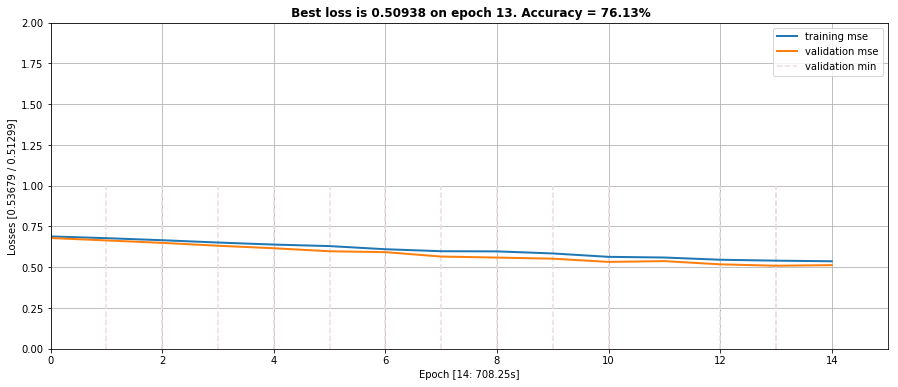

In [19]:
model_name = models_dir+fire_model 
ploss = 2.0
nepochs = 15

if True: 
    print("[INFO] creating model...")
    my_big_callback = TrainingPlotter(n=1, filepath=model_name, patience=10)
    
    print("[INFO] compiling model...")
    vgg16_tr_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"]) 
    print("[INFO] done compiling model...")
    
else:
    print("[INFO] loading model...")
    vgg16_tr_model, my_big_callback = load_model_and_history(model_name)

past_epochs = my_big_callback.get_nepochs()

fig = plt.figure(figsize=(15,6))
plt.ylim(0.0, ploss)
plt.xlim(0, nepochs)
plt.grid(True)

print("[INFO] training...")
try:
    vgg16_tr_model.fit(X_train, Y_train, batch_size=64, nb_epoch=nepochs,
                       verbose=0, validation_split=0.33, callbacks = [my_big_callback])
except KeyboardInterrupt:
    pass

print("[INFO] evaluating...")
loss, accuracy = vgg16_tr_model.evaluate(X_test, Y_test, batch_size=128, verbose=0)

print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

In [23]:
for layer in vgg16_tr_model.layers:
    layer.trainable = True
    
vgg16_tr_model.save_weights(models_dir+fire_vgg16_name)